# Preparation

Import everything and load data from cache file

In [1]:
%matplotlib inline
import numpy as np
from keras import Model, Input
from keras.layers import LSTM, Dropout, Dense, multiply, Conv1D, MaxPooling1D, Flatten
from keras import backend as K
from matplotlib import pyplot as plt

x_train = np.load('cache/x_train.npy')
y_train = np.load('cache/y_train.npy')

/home/ethan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train.shape, y_train.shape

((369933, 72, 8), (369933, 12, 8))

# Make a model

In [3]:
def future_direction_conv(input_shape):
    inputs = Input(shape=input_shape[1:])

    f = Conv1D(16, 6, padding='valid', activation='relu')(inputs)
    p = MaxPooling1D()(f)

    f = Conv1D(32, 6, padding='valid', activation='relu')(p)
    p = MaxPooling1D()(f)

    f = Conv1D(64, 6, padding='valid', activation='relu')(p)
    p = MaxPooling1D()(f)

    f = Conv1D(128, 6, padding='same', activation='relu')(p)
    p = MaxPooling1D()(f)

    f = Conv1D(256, 6, padding='same', activation='relu')(p)
    p = MaxPooling1D()(f)

    feature_vec = Flatten()(p)

    d = Dense(1, activation='sigmoid', name='direction')(feature_vec)

    model = Model(inputs=inputs, outputs=d)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

# Train the model

In [4]:
mini_x = x_train[:]
mini_y = y_train[:]

model = future_direction_conv(mini_x.shape)
prices_train = mini_y[:, -1, 0]
price_diff = prices_train - mini_x[:, -1, 0]
labels = price_diff > 0
train_history = model.fit(mini_x, labels, epochs=10, batch_size=128, shuffle=True)
print('\nTraining complete!\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 67, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 64)             0         
__________

# Evaluate the performance

In [9]:
x_valid = np.load('cache/x_valid.npy')
y_valid = np.load('cache/y_valid.npy')

last_prices = x_valid[:, -1, 0]
prices_valid = y_valid[:, -1, 0]
diff_valid = prices_valid - last_prices
dir_valid = diff_valid > 0

performance = model.evaluate(x_valid, dir_valid)
print(performance)

dir_pred = model.predict(x_valid, verbose=True)
print(dir_pred.shape)

41104/41104 [==============================] - 2s 57us/step
[0.5589099841017628, 0.7192487349163098]
41104/41104 [==============================] - 2s 50us/step
(41104, 1)


In [10]:
dir_pred = dir_pred.squeeze()

dir_pred = dir_pred > .5

correct_dirs = np.sum(dir_valid == dir_pred)
acc = correct_dirs / len(dir_valid)

print("Direction Accuracy: {:.3f}%".format(acc * 100))

Direction Accuracy: 71.925%


# Visualization

(72, 8) (12, 8)


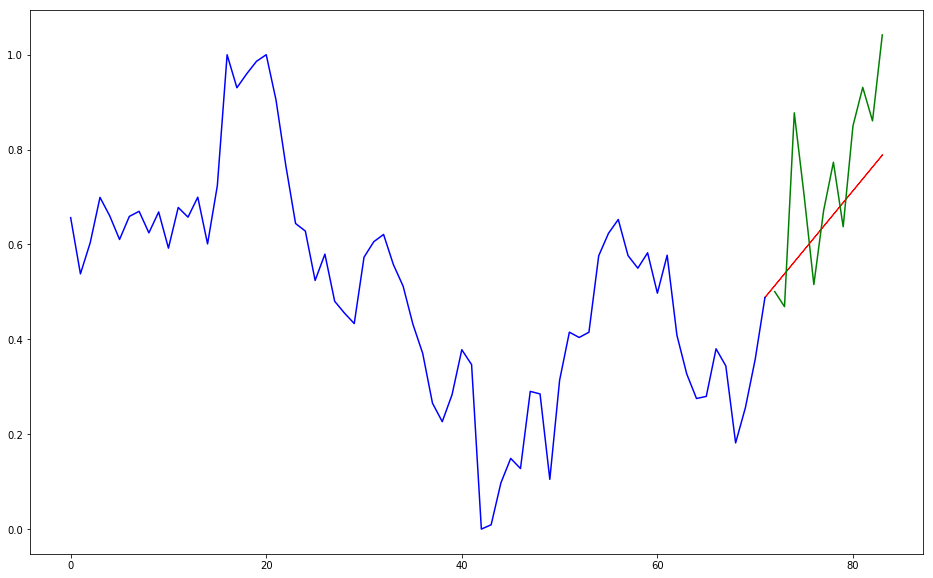

In [39]:
sample_id = np.random.randint(len(x_valid))
# sample_id = 7
sample_x = x_valid[sample_id]
sample_y = y_valid[sample_id]
prediction = dir_pred[sample_id]
print(sample_x.shape, sample_y.shape)

direction = (np.float64(prediction) * 2 - 1) * .3

hist_length = len(sample_x)
fut_length = len(sample_y)

plt.figure(figsize=[16, 10])
# prices
plt.plot(range(hist_length), sample_x[:, 0], 'b')
# reality
plt.plot(range(hist_length, hist_length + fut_length), sample_y[:, 0], 'g')

plt.arrow(hist_length - 1, sample_x[-1, 0], fut_length, direction, color='r')